# North Korean Missile Tests
---

The James Martin Center for Nonproliferation Studies North Korea Missile Test Database is the first database to record flight tests of all missiles launched by North Korea capable of delivering a payload of at least 500 kilograms (1102.31 pounds) a distance of at least 300 kilometers (186.4 miles). The database captures advancements in North Korea's missile program by documenting all such tests since the first one occurred in April 1984, and will be routinely updated as events warrant.

https://data.world/ian/the-cns-north-korea-missile-test-database

http://www.nti.org/analysis/articles/cns-north-korea-missile-test-database/

http://www.nti.org/analysis/articles/understanding-north-koreas-missile-tests/

In [1]:
from __future__ import division

import math
import copy
import sys
import os

import warnings
warnings.filterwarnings('ignore')

sys.path.extend([r'C:\Users\michael\Documents\_python\modules'])
import data_science_tools as dst
import data_visualization_tools as vst

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

In [2]:
# get the data dictionary
data_dictionary = pd.read_csv(
    r'./north-korea-missile-test-database-data-dictionary.csv', index_col=2)

# a quick function to get field descriptions as needed
def field_description(col, dd_df=data_dictionary):
    file_, table_, type_, desc_ = dd_df[dd_df.index == col].values[0]
    print 'Table: {}\nField: {}\n\nDescription: {}'.format(table_, col, desc_)

In [3]:
# get the launch data
launches = pd.read_excel(
    r'./north_korea_missile_tests_database_050217.xlsx', 
    sheetname='Missile Tests', header=0)
launches = launches.convert_objects(convert_dates=True, convert_numeric=True)

drop_cols = ['Date Entered/Updated', 'Launch Agency/Authority', 'Other Name',
             'Additional Information', 'Source(s)', 'Confirmation Status']
launches.drop(drop_cols, axis=1, inplace=True)

launches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 12 columns):
F1                         106 non-null int64
Date                       106 non-null datetime64[ns]
Missile Name               106 non-null object
Missile Type               106 non-null object
Facility Name              106 non-null object
Facility Location          106 non-null object
Facility Latitude          105 non-null float64
Facility Longitude         105 non-null float64
Landing Location           96 non-null object
Apogee (km)                45 non-null float64
Distance Travelled (km)    33 non-null float64
Success                    106 non-null object
dtypes: datetime64[ns](1), float64(4), int64(1), object(6)
memory usage: 10.0+ KB


In [4]:
# get the facility data
facilities = pd.read_excel(
    r'./north_korea_missile_tests_database_050217.xlsx', 
    sheetname='Facilities', header=0)
facilities = facilities.convert_objects(
    convert_dates=True, convert_numeric=True)

facilities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 7 columns):
Facility                    16 non-null object
Date of First Test          16 non-null datetime64[ns]
Date of Most Recent Test    16 non-null datetime64[ns]
Number of Tests             16 non-null int64
Latitude                    14 non-null float64
Longitude                   14 non-null float64
Location                    15 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 968.0+ bytes


In [5]:
# facility as key
print
print 'Every launch facility name is in the facilities table:'
print set(launches['Facility Name'].unique()).issubset(
      set(facilities.Facility.unique()))
print


Every launch facility name is in the facilities table:
True



In [6]:
launch_loc_cols = \
['Facility Name','Facility Latitude','Facility Longitude','Facility Location']
launch_loc = launches[launch_loc_cols].copy()
launch_loc = launch_loc.drop_duplicates(launch_loc_cols)

facility_loc_cols = ['Facility', 'Latitude', 'Longitude', 'Location']
facility_loc = facilities[facility_loc_cols].copy()
facility_loc = facility_loc.drop_duplicates(facility_loc_cols)

launch_loc.columns = facility_loc.columns

launch_loc = launch_loc.dropna().sort('Facility').reset_index(drop=True)
facility_loc = facility_loc.dropna().sort('Facility').reset_index(drop=True)

print 
print 'Launch location data matches facility location data:'
print np.all(launch_loc.isin(facility_loc))
print


Launch location data matches facility location data:
True



In [7]:
# drop the redundant location data
launches.drop(launch_loc_cols[1:], axis=1, inplace=True)

# binarize confirmation and success
launches['Success'].replace(
    ['Success', 'Failure', 'Unknown'], [1, 0, np.nan], inplace=True)
launches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 9 columns):
F1                         106 non-null int64
Date                       106 non-null datetime64[ns]
Missile Name               106 non-null object
Missile Type               106 non-null object
Facility Name              106 non-null object
Landing Location           96 non-null object
Apogee (km)                45 non-null float64
Distance Travelled (km)    33 non-null float64
Success                    104 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 7.5+ KB


In [8]:
def describe_variable(df, var):
    field_description(var)
    vc = df[var].value_counts()
    vc.plot(kind='bar')
    return vc

Table: Missile Tests
Field: Facility Name

Description: This is the name of the site the launch was carried out at. This should be interpreted as a general location for each test and not as an exact location. 


North Wonsan                          20
Kittaeryong Missile Base              17
Tonghae Satellite Launching Ground    17
Hwangju                               12
Wonsan Kalma International Airport    11
Sinpo Shipyard                         8
Sohae Satellite Launching Station      7
Sunchon Airbase                        4
Kaesong                                2
Nampo                                  2
Panghyon Airbase                       2
Kusong Testing Ground                  1
Pukchang Airfield                      1
Unknown                                1
Chihari Missile Base                   1
Name: Facility Name, dtype: int64

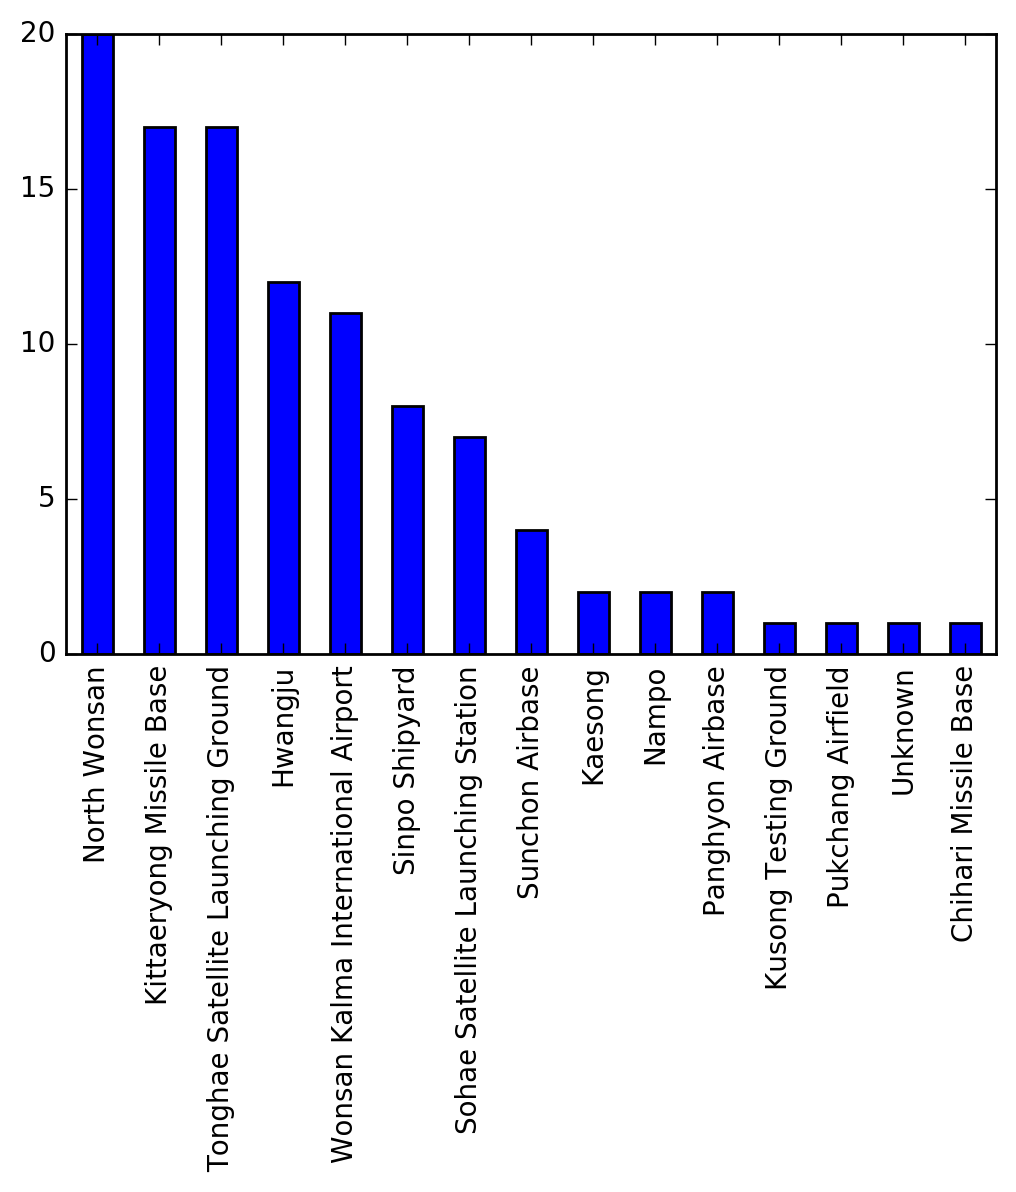

In [9]:
variable = 'Facility Name'
describe_variable(launches, variable)

Table: Missile Tests
Field: Missile Type

Description: This is what category the missile falls under, example: Short-Range Ballistic Missile (SRBM), Mid-Range Ballistic Missile (MRBM), Intermediate-Range Ballistic Missile (IRBM), Intercontinental Ballistic Missile (ICBM), Satellite Launch Vehicle (SLV), Submarine-Launched Ballistic Missile (SLBM).


SRBM       59
MRBM       24
IRBM        8
SLV         6
SLBM        6
Unknown     3
Name: Missile Type, dtype: int64

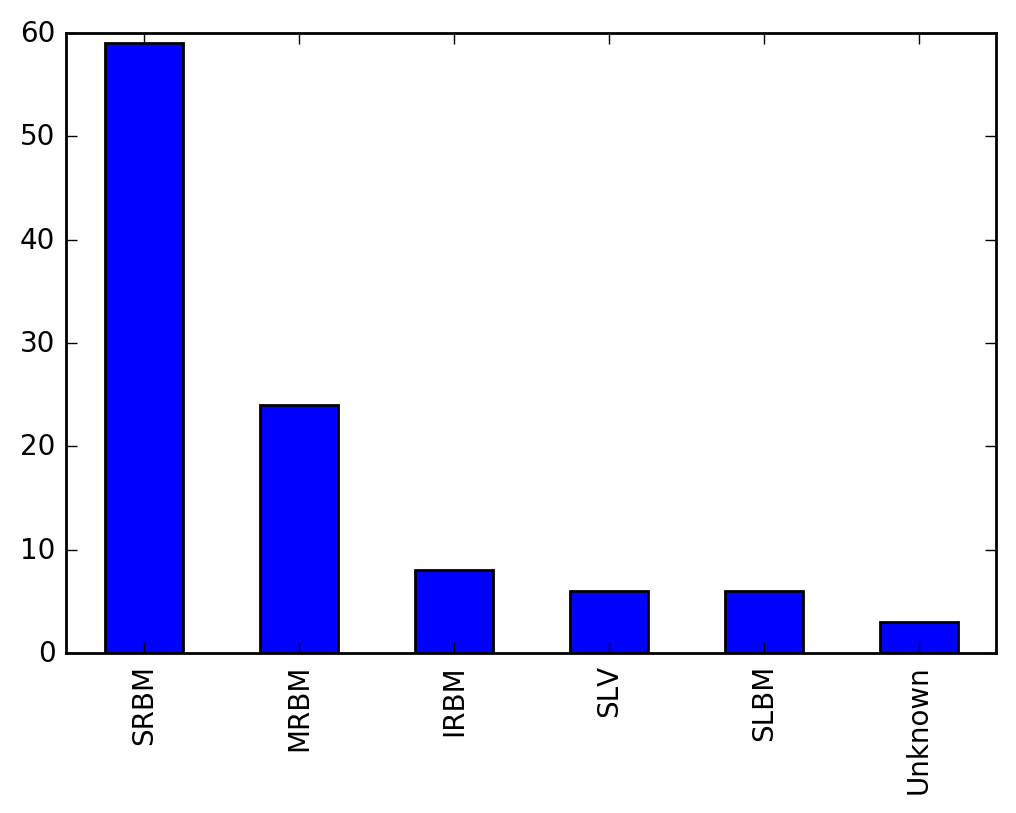

In [10]:
variable = 'Missile Type'
describe_variable(launches, variable)

Table: Missile Tests
Field: Missile Name

Description: This is the missile type believed to have been launched. In some cases there may be confusion or uncertainty regarding the exact type launch. 


Scud-C         27
KN-02          20
Nodong         16
Scud-B         10
Musudan         8
ER Scud         7
Polaris-1       6
Unknown         3
Unha-3          3
KN-17           2
Unha            2
Taepodong-1     1
Polaris-2       1
Name: Missile Name, dtype: int64

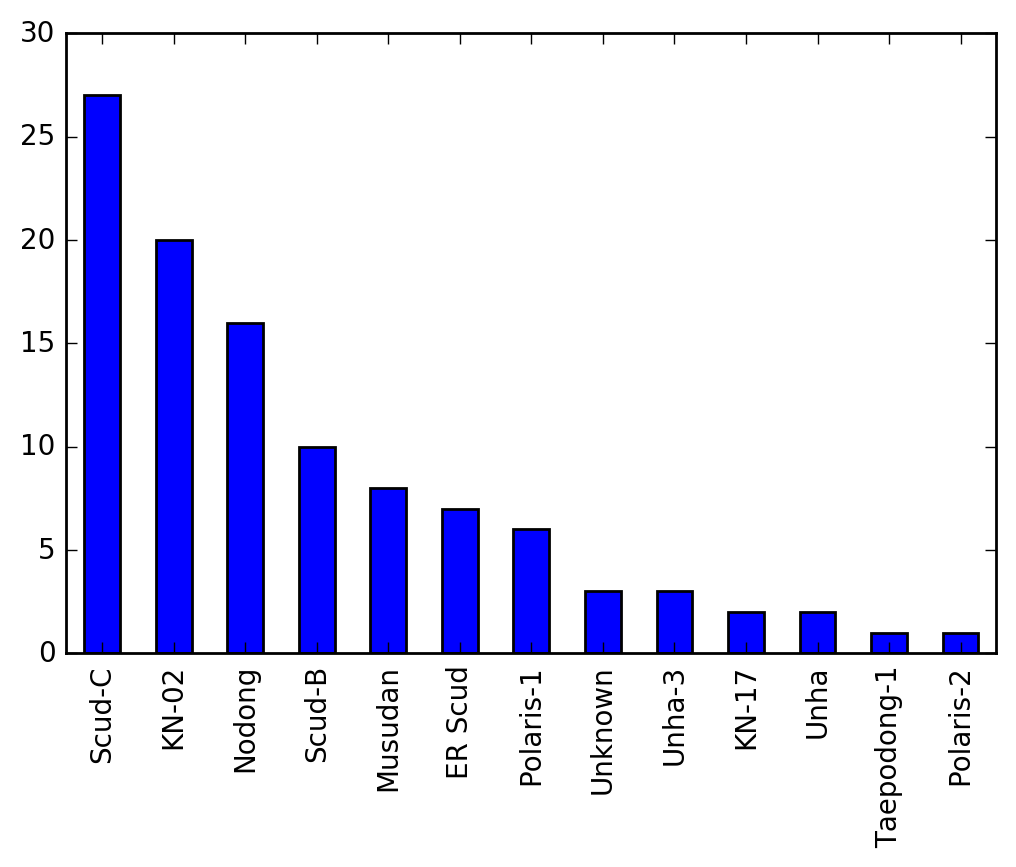

In [11]:
variable = 'Missile Name'
describe_variable(launches, variable)

Table: Missile Tests
Field: Landing Location

Description: An approximate location for where the missile landed. For tests which fail almost immediately after launch and for tests in which the payload enters orbit this is listed as N/A.


Sea of Japan or East Sea    76
Unknown                     17
Pacific Ocean                2
330 east of Hachinohe        1
Name: Landing Location, dtype: int64

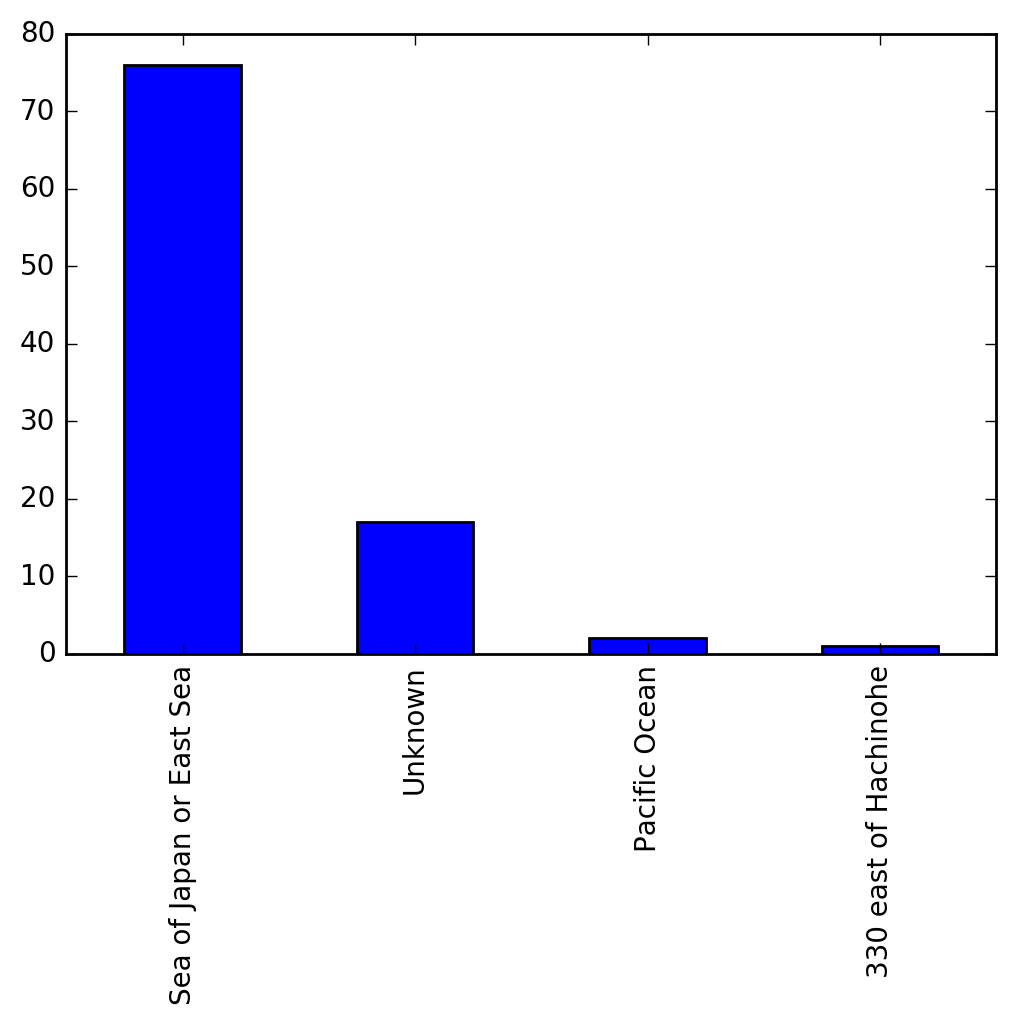

In [12]:
variable = 'Landing Location'
describe_variable(launches, variable)

Table: Missile Tests
Field: Success

Description:  Unknown = not enough information regarding the test to be sure of its outcome. Failure = catastrophic failure during the flight test of the missile, i.e. the missile exploding. Success = as that not happening during the flight test...


1.0    79
0.0    25
Name: Success, dtype: int64

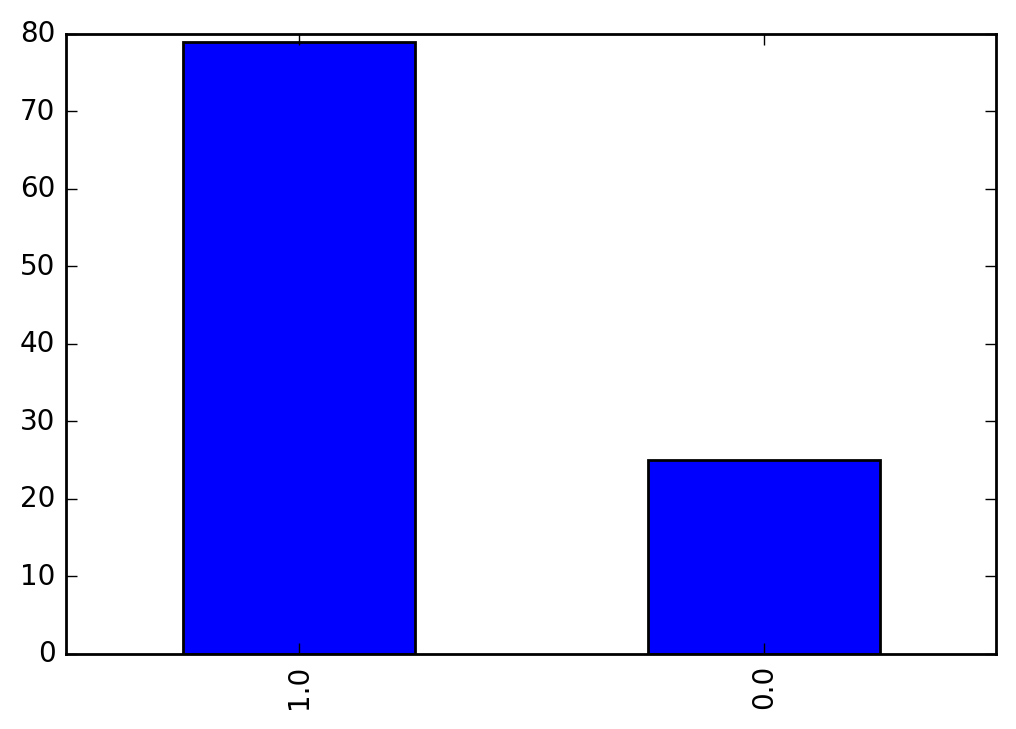

In [13]:
variable = 'Success'
describe_variable(launches, variable)

http://server.arcgisonline.com/ArcGIS/rest/services/World_Shaded_Relief/MapServer/export?bbox=-68777.3848663,337731.993324,563921.044575,1120552.11995&bboxSR=2097&imageSR=2097&size=1500,1855&dpi=96&format=png32&f=image


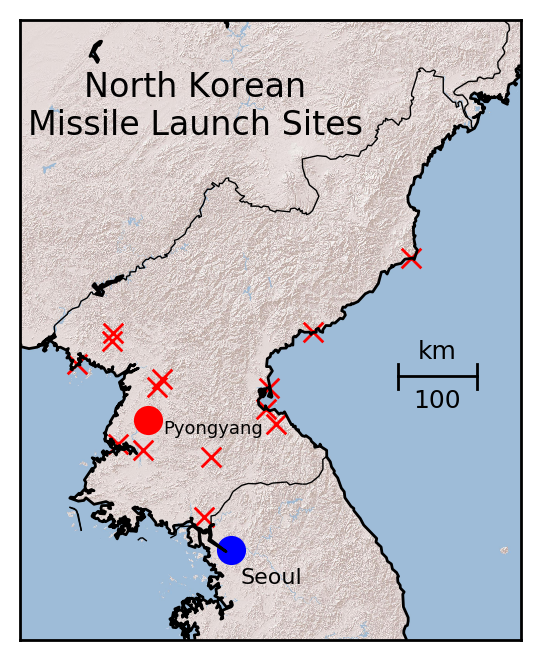

In [119]:
# m = Basemap(llcrnrlon=124., llcrnrlat=36.5, urcrnrlon=131.5, urcrnrlat=43.5,
#             projection='lcc', lat_1=39., lat_2=42., lon_0=128.,
#             resolution='i')
m = Basemap(llcrnrlon=124., llcrnrlat=36.5, urcrnrlon=131.5, urcrnrlat=43.5,
            lat_1=39., lat_2=42., lon_0=128.,resolution='i', epsg=2097)

# plot launch sites
plot_facilities = facilities.copy().dropna()
xs = plot_facilities.Longitude.tolist()
ys = plot_facilities.Latitude.tolist()
m.scatter(x=xs, y=ys, marker='x', color='r', s=50, latlon=True, alpha=1.)

# plot Seoul
m.scatter(x=[126.978], y=[37.5665], marker='o', color='b', s=90, latlon=True)

# plot Pyongyang
m.scatter(x=[125.7625], y=[39.0392], marker='o', color='r', s=90, latlon=True)

m.drawcountries()
m.drawcoastlines()
m.drawmapboundary()
m.drawmapscale(130, 39.5, 131, 41.5, 100)
# m.fillcontinents(color='lightblue', alpha=0.25)
m.arcgisimage(service='World_Shaded_Relief', xpixels=1500, verbose=True)

# title
plt.annotate('North Korean\nMissile Launch Sites', xy=(0.35, 0.86),  
             xycoords='axes fraction', fontsize=12,
             horizontalalignment='center', verticalalignment='center')

# label Seoul
plt.annotate('Seoul', xy=(0.5, 0.1), xycoords='axes fraction',
             xytext=(.15, -.05), textcoords='offset points', fontsize=8,
             horizontalalignment='center', verticalalignment='center')

# label Pyongyang
plt.annotate('Pyongyang', xy=(0.385, 0.34), xycoords='axes fraction',
             xytext=(.15, .0), textcoords='offset points', fontsize=6.5,
             horizontalalignment='center', verticalalignment='center')

plt.show();